In [12]:
from typing import List
import pandas as pd
import chess
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from nlpChess.utils.DatasetLoader import loadConcatenatedDataset
ds = loadConcatenatedDataset()
df = ds.to_pandas()

In [13]:
pieces_moves = df[['pieces', 'Moves']]

In [14]:
#concatenate piece to respective moves
def concatenate_pieces_moves(pieces: List[str], moves: List[str]) -> str:
    return ' '.join([f"{piece}{move}" for piece, move in zip(pieces, moves)])

pieces_moves = pieces_moves.apply(
    lambda row: concatenate_pieces_moves(row['pieces'], row['Moves']), axis=1)

In [15]:
#  make every row of pieces_moves a list
pieces_moves_list = pieces_moves.apply(lambda x: x.split())

In [17]:
# make pieces_moves a  list of lists
pieces_moves_list = pieces_moves_list.tolist()

In [18]:
pieces_moves_list

[['pe2e4',
  'pg7g6',
  'ng1f3',
  'bf8g7',
  'pd2d4',
  'pd7d6',
  'bf1d3',
  'pe7e5',
  'bc1g5',
  'ng8e7',
  'pd4e5',
  'pd6e5',
  'nb1c3',
  'ph7h6',
  'bg5e3',
  'nb8c6',
  'qd1d2',
  'nc6d4',
  'bd3c4',
  'bc8h3',
  'nf3e5',
  'bg7e5',
  'pf2f4',
  'bh3e6',
  'pf4e5',
  'be6c4',
  'be3d4',
  'bc4e6',
  'qd2f2',
  'ne7c6',
  'bd4e3',
  'nc6e5',
  'ra1d1',
  'ne5d7',
  'ke1g1',
  'qd8e7',
  'nc3b5',
  'ke8c8',
  'qf2f4',
  'nd7b6',
  'nb5a7',
  'kc8b8',
  'be3b6',
  'be6c4',
  'rf1e1',
  'rd8d7',
  'rd1d7',
  'qe7d7',
  'pb2b3',
  'bc4e6',
  'bb6f2',
  'rh8d8',
  'pc2c4',
  'qd7d2',
  'qf4d2',
  'rd8d2',
  'na7b5',
  'be6d7',
  'nb5c3',
  'rd2c2',
  'nc3d5',
  'rc2a2',
  'bf2g3',
  'bd7c6',
  'bg3c7',
  'kb8c8',
  'bc7f4',
  'pg6g5',
  'bf4g3',
  'kc8d7',
  're1f1',
  'kd7e8',
  'pb3b4',
  'bc6a4',
  'rf1c1',
  'ba4c2',
  'rc1e1',
  'ke8d7',
  'pb4b5',
  'ra2b2',
  'ph2h3',
  'rb2b3',
  'nd5e3',
  'bc2e4',
  'ne3g4',
  'pf7f5',
  'ng4f6',
  'kd7e6',
  'nf6e4',
  'pf5e4',
  'bg3b8',

In [21]:
from collections import defaultdict
import numpy as np
import pandas as pd


def get_cooccurrence_matrix(moves: List[List[str]], offset: int) -> pd.DataFrame:
    """
    Create a co-occurrence matrix for the given moves with a specified offset.
    
    Args:
        moves (List[List[str]]): List of games, each containing a list of moves.
        offset (int): The offset to consider for co-occurrence.
    
    Returns:
        pd.DataFrame: Co-occurrence matrix.
    """
    co_occurrence = defaultdict(lambda: defaultdict(int))
    
    for game in tqdm(moves):
        for idx, move in enumerate(game):
            neighbor_idx = idx + offset
            if neighbor_idx >= (len(game) - 1):
                break
            neighbor_move = game[neighbor_idx]
            co_occurrence[move][neighbor_move] += 1

    unique_moves = list(sorted(set(m for game in moves for m in game)))
    move_idx_map = {k: v for v, k in enumerate(unique_moves)}
    matrix = np.zeros((len(unique_moves), len(unique_moves)))

    for move, value in tqdm(co_occurrence.items()):
        move_idx = move_idx_map[move]
        for neighbor_move, count in value.items():
            neighbor_move_idx = move_idx_map[neighbor_move]
            matrix[move_idx, neighbor_move_idx] = count
    count_df = pd.DataFrame(matrix, columns=unique_moves, index=unique_moves)
    return count_df
# Example input
offset = 2
count_df = get_cooccurrence_matrix(pieces_moves_list, offset)
matrix = count_df.values

100%|██████████| 4075/4075 [00:01<00:00, 3899.05it/s]


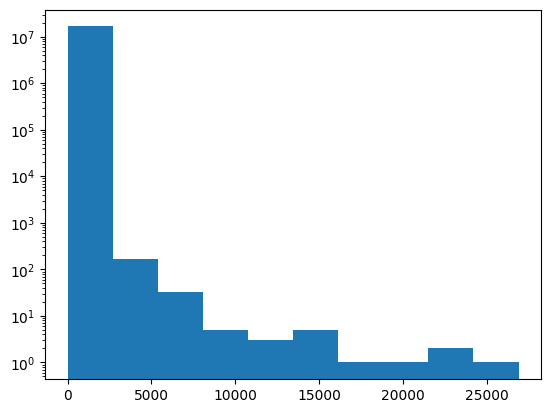

In [22]:
plt.hist(matrix.flatten())
plt.yscale("log")

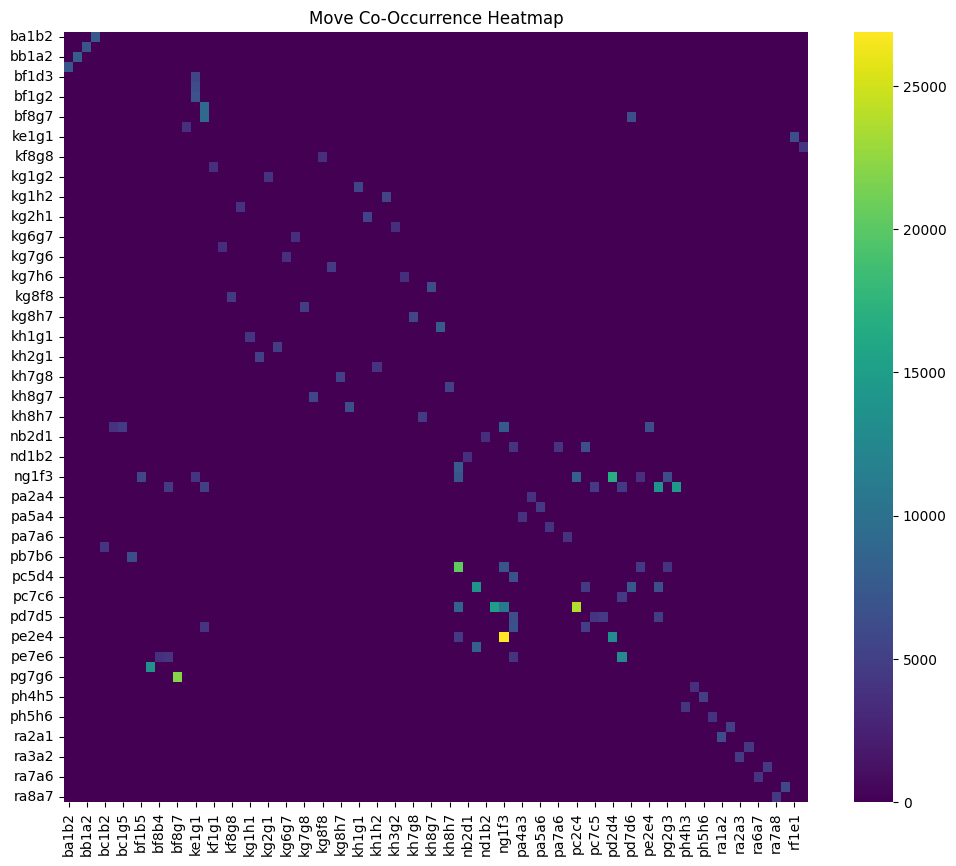

In [23]:
def prune_count_df(count_df: pd.DataFrame, threshold: int) -> pd.DataFrame:
    """
    Prune the count DataFrame by removing rows and columns with counts below a certain threshold.
    
    Args:
        count_df (pd.DataFrame): The count DataFrame to prune.
        threshold (int): The threshold for pruning.
    
    Returns:
        pd.DataFrame: The pruned count DataFrame.
    """
    pruned_df = count_df.copy()
    pruned_df[pruned_df <= threshold] = 0
    pruned_df = pruned_df.drop(pruned_df[pruned_df.sum(axis=1) == 0].index)
    drop_cols = pruned_df.columns[pruned_df.sum(axis=0) == 0]
    pruned_df = pruned_df.drop(columns=drop_cols)
    return pruned_df

mini_df = prune_count_df(count_df, 3500)
# prune rows and columns under a certain count
plt.figure(figsize=(12, 10))
sns.heatmap(mini_df, cmap="viridis")
plt.title("Move Co-Occurrence Heatmap")
plt.show()

<Figure size 1500x800 with 0 Axes>

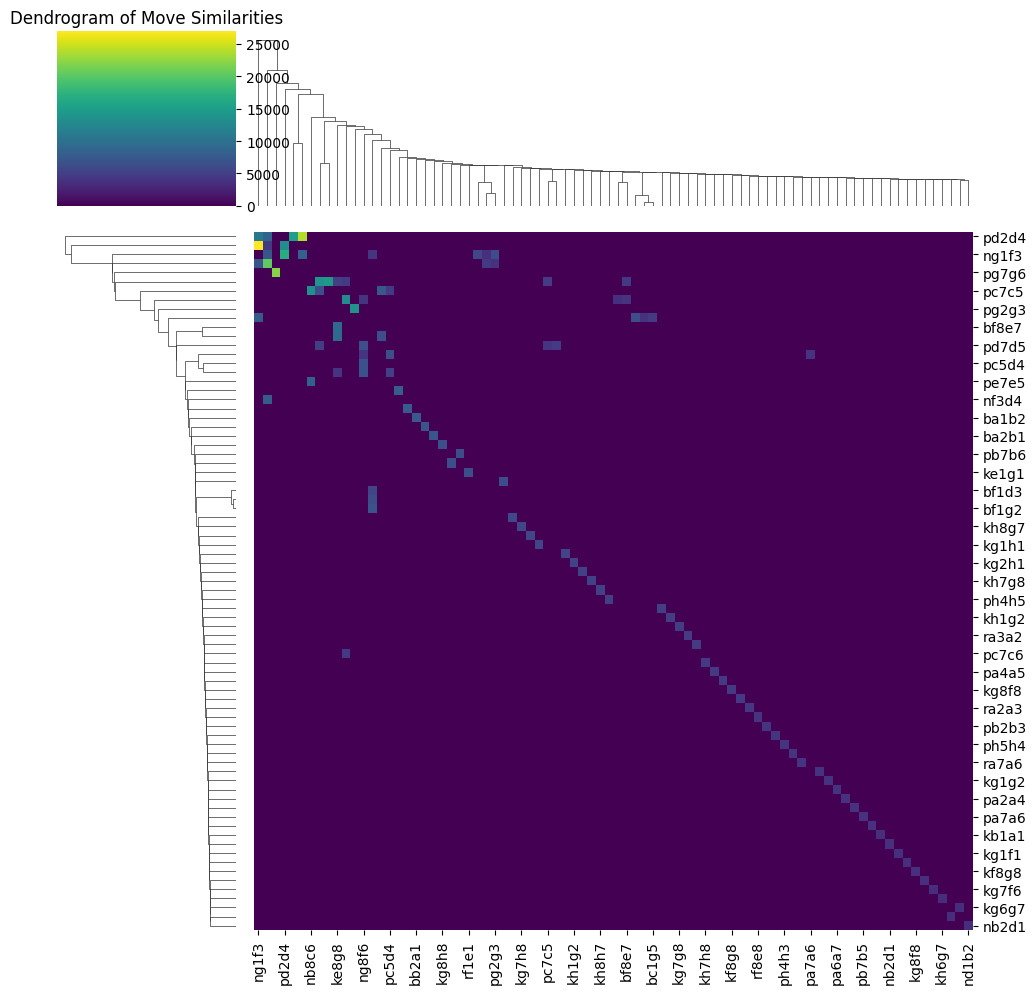

In [24]:
from scipy.cluster.hierarchy import linkage, dendrogram

# Use linkage on the condensed distance matrix
linkage_matrix = linkage(mini_df, method='ward')

plt.figure(figsize=(15, 8))
sns.clustermap(mini_df, cmap="viridis")
plt.title("Dendrogram of Move Similarities")
plt.tight_layout()
plt.show()


In [26]:
moves = df['Moves'].tolist()

100%|██████████| 1959/1959 [00:00<00:00, 8434.91it/s]
c:\Users\marti\NLP-Project\.conda\Lib\site-packages\pandas\core\internals\blocks.py:393: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
100%|██████████| 1959/1959 [00:00<00:00, 10165.75it/s]
c:\Users\marti\NLP-Project\.conda\Lib\site-packages\pandas\core\internals\blocks.py:393: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
100%|██████████| 1959/1959 [00:00<00:00, 7729.54it/s]
c:\Users\marti\NLP-Project\.conda\Lib\site-packages\pandas\core\internals\blocks.py:393: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
100%|██████████| 1959/1959 [00:00<00:00, 8261.89it/s]
c:\Users\marti\NLP-Project\.conda\Lib\site-packages\pandas\core\internals\blocks.py:393: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
100%|██████████| 1959/1959 [00:00<00:00, 6600.75it/s]
c:\Users\marti\NL

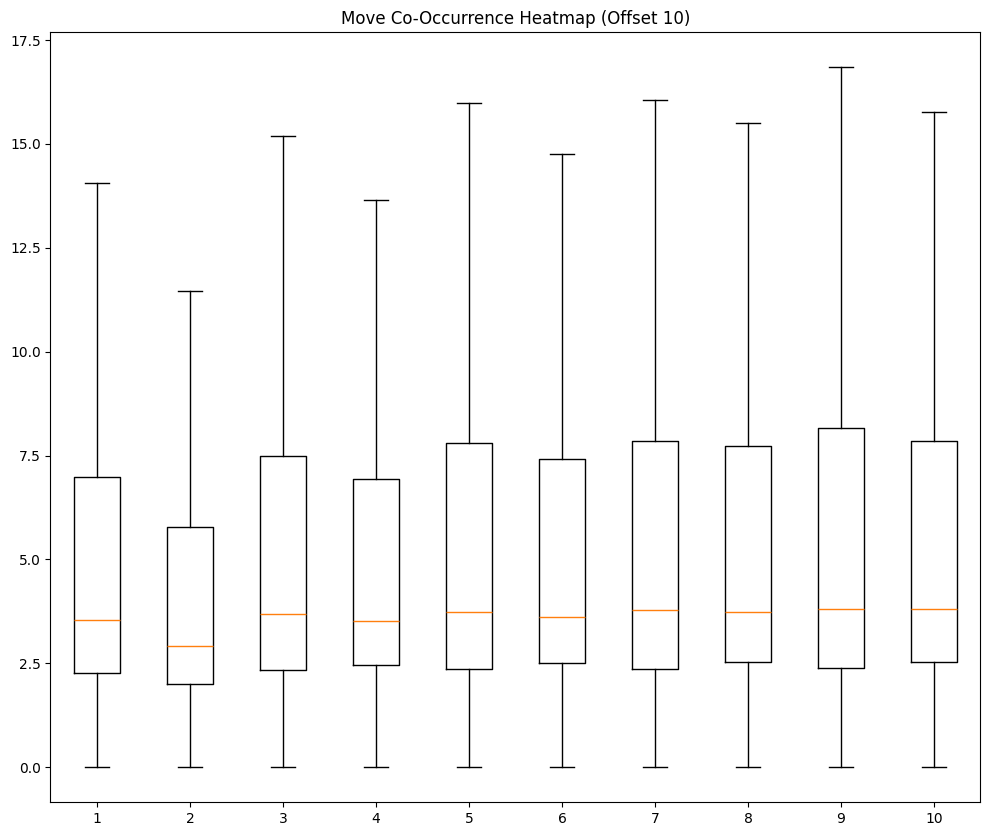

In [27]:
plt.figure(figsize=(12, 10))
bins = np.linspace(0, 40, 101)
for offset in np.arange(1, 11):
    count_df = get_cooccurrence_matrix(moves, offset)
    count_df.sort_index(inplace=True)
    p = count_df / count_df.sum(axis=1)
    entropy = -np.sum(p * np.nan_to_num(np.log(p), copy=True, neginf=0), axis=1)
    plt.boxplot(entropy, positions=[offset], widths=0.5, showfliers=False)
plt.title(f"Move Co-Occurrence Heatmap (Offset {offset})")
plt.show()

